In [91]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np

import os
import random
from shutil import copyfile

In [92]:
HEIGHT =64
WIDTH = 64
TARGET_SIZE = (HEIGHT, WIDTH)

In [93]:
# Unzip file
import tarfile

filename = 'dataset/synthetic_sugarbeet_random_weeds'

# my_tar = tarfile.open(filename + '.tar.gz')
# my_tar.extractall('dataset')
# my_tar.close()

In [94]:
def make_directory(fullpath):
    splitted_data = fullpath.split('/')
    
    new_dir = []
    current_dir = '.'
    
    for folder in splitted_data:           
        current_dir = current_dir + '/' + folder                
        if not os.path.isdir(current_dir + '/'):
            new_dir.append(current_dir)
            os.mkdir(current_dir)
    
    return new_dir
    
print(make_directory('dataset/synthetic_sugarbeet_random_weeds/tom/fougere/'))

[]


In [95]:
# Write a python function called split_data which takes
# a FOLDER_IMAGES directory containing the images
# a FOLDER_MASKS directory containing the masks
# a TARGET_FOLDER directory where the files will be copied to
# the TARGET_FOLDER directory will contain 2 subfolders train and test with the data splitted
# a SPLIT SIZE to determine the portion
# The files should also be randomized, so that the training set is a random
# X% of the files, and the test set is the remaining files
# SO, for example, if SPLIT SIZE is .9
# Then 90% of the images will be copied to the TRAINING dir
# and 10% of the images will be copied to the TESTING dir
# Also -- All images should be checked, and if they have a zero file length,
# they will not be copied over
def split_data(FOLDER_IMAGES, FOLDER_MASKS, TARGET_FOLDER, SPLIT_SIZE):

    TRAINING_FOLDER_NAME = TARGET_FOLDER + '/train/'
    TESTING_FOLDER_NAME = TARGET_FOLDER + '/test/'
    TRAINING_FOLDER_NAME_IMAGES = TARGET_FOLDER + '/train/images/img/'
    TRAINING_FOLDER_NAME_MASKS = TARGET_FOLDER + '/train/masks/img/'
    TESTING_FOLDER_NAME_IMAGES = TARGET_FOLDER + '/test/images/img/'
    TESTING_FOLDER_NAME_MASKS = TARGET_FOLDER + '/test/masks/img/'

    # Create directories
    make_directory(TRAINING_FOLDER_NAME_IMAGES)
    make_directory(TRAINING_FOLDER_NAME_MASKS)
    make_directory(TESTING_FOLDER_NAME_IMAGES)
    make_directory(TESTING_FOLDER_NAME_MASKS)
    
    # Remove all data in TRAINING and TESTING dir
    for i_file in os.listdir(TRAINING_FOLDER_NAME_IMAGES):
        os.remove(TRAINING_FOLDER_NAME_IMAGES + i_file)
    for i_file in os.listdir(TRAINING_FOLDER_NAME_MASKS):
        os.remove(TRAINING_FOLDER_NAME_MASKS + i_file)
    for i_file in os.listdir(TESTING_FOLDER_NAME_IMAGES):
        os.remove(TESTING_FOLDER_NAME_IMAGES + i_file)
    for i_file in os.listdir(TESTING_FOLDER_NAME_MASKS):
        os.remove(TESTING_FOLDER_NAME_MASKS + i_file)
    
    dataset = []
    
    # Check for z zero file length
    for i_file in os.listdir(FOLDER_IMAGES):
        data = i_file
        if (os.path.getsize(FOLDER_IMAGES + data) > 0):
            dataset.append(i_file)
        else:
            print('Skipped ' + i_file)
            print('Invalid file size! i.e Zero length.')
    
    # Number of files
    nb_files = len(dataset)
    nb_files_training = int(nb_files * SPLIT_SIZE)
    nb_files_testing = nb_files - nb_files_training
    
    # Suffle dataset
    shuffled_dataset = random.sample(dataset, len(dataset))
        
    # Copy files
    for i_num, i_file in enumerate(shuffled_dataset):
        if i_num < nb_files_training:
            new_path_images = TRAINING_FOLDER_NAME_IMAGES + i_file
            new_path_masks = TRAINING_FOLDER_NAME_MASKS + i_file
        else:
            new_path_images = TESTING_FOLDER_NAME_IMAGES + i_file
            new_path_masks = TESTING_FOLDER_NAME_MASKS + i_file
            
        copyfile(FOLDER_IMAGES + i_file, new_path_images)
        copyfile(FOLDER_MASKS + i_file, new_path_masks)

In [96]:
# Split data
FOLDER_IMAGES = "dataset/synthetic_sugarbeet_random_weeds/rgb/"
FOLDER_MASKS = "dataset/synthetic_sugarbeet_random_weeds/gt/"
TARGET_FOLDER = "dataset/synthetic_sugarbeet_random_weeds/train_test/"

split_size = .9
split_data(FOLDER_IMAGES, FOLDER_MASKS, TARGET_FOLDER, split_size)

Number of trained images: 1126
(360, 480, 3)


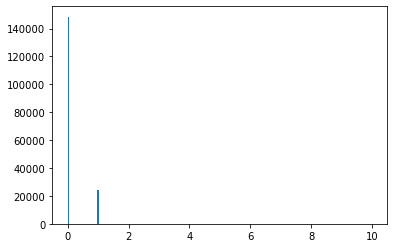

In [97]:
# Plot image
import cv2
import matplotlib.pyplot as plt

pathname = 'train/masks/img/'

list_files = os.listdir(TARGET_FOLDER + pathname)
nb_files = len(list_files)
print('Number of trained images:', nb_files)
 
img_example = cv2.imread(TARGET_FOLDER + pathname + list_files[1])
# cv2.imshow('Example', img_example) 
# cv2.waitKey(0)

print(img_example.shape)

plt.hist(img_example[:,:,0].ravel(), 256, [0,10]);
plt.show()

In [98]:
def preprocessing_reshape(img):
    return img[:,:,0]

In [99]:
# Data augmentation (for train dataset)
SEED = 1

train_image_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1/255.,
                                                                horizontal_flip=True,
                                                                rotation_range=20,
                                                                zoom_range=0.2,
                                                                width_shift_range = 0.1,
                                                                height_shift_range = 0.1)
train_image_generator= train_image_datagen.flow_from_directory(TARGET_FOLDER + 'train/images',
                                                               batch_size=10,
                                                               target_size=TARGET_SIZE,
                                                               class_mode=None,
                                                               seed=SEED)

train_mask_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                                                                horizontal_flip=True,
                                                                rotation_range=20,
                                                                zoom_range=0.2,
                                                                width_shift_range = 0.1,
                                                                height_shift_range = 0.1,
                                                                preprocessing_function=preprocessing_reshape)
train_mask_generator= train_image_datagen.flow_from_directory(TARGET_FOLDER + 'train/masks/',
                                                               batch_size=10,
                                                               target_size=TARGET_SIZE,
                                                               class_mode=None,
                                                               seed=SEED)

Found 1126 images belonging to 1 classes.
Found 1126 images belonging to 1 classes.


In [100]:
# Data augmentation (for validation dataset)
SEED = 1

val_image_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1/255.)
val_image_generator= val_image_datagen.flow_from_directory(TARGET_FOLDER + 'test/images',
                                                               batch_size=10,
                                                               target_size=TARGET_SIZE,
                                                               class_mode=None,
                                                               seed=SEED)

val_mask_datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocessing_reshape)
val_mask_generator= val_image_datagen.flow_from_directory(TARGET_FOLDER + 'test/masks/',
                                                               batch_size=10,
                                                               target_size=TARGET_SIZE,
                                                               class_mode=None,
                                                               seed=SEED)

Found 126 images belonging to 1 classes.
Found 126 images belonging to 1 classes.


In [101]:
# Create generator
def my_image_mask_generator(image_data_generator, mask_data_generator):
    new_generator = zip(image_data_generator, mask_data_generator)
    for (img, mask) in new_generator:
        yield (img, mask, [])

In [102]:
# parameter describing where the channel dimension is found in our dataset
IMAGE_ORDERING = 'channels_last'

def conv_block(input, filters, strides, pooling_size, pool_strides):
  '''
  Args:
    input (tensor) -- batch of images or features
    filters (int) -- number of filters of the Conv2D layers
    strides (int) -- strides setting of the Conv2D layers
    pooling_size (int) -- pooling size of the MaxPooling2D layers
    pool_strides (int) -- strides setting of the MaxPooling2D layers
  
  Returns:
    (tensor) max pooled and batch-normalized features of the input 
  '''
  # use the functional syntax to stack the layers as shown in the diagram above
  x = tf.keras.layers.Conv2D(filters, strides, padding='same', data_format=IMAGE_ORDERING)(input)
  x= tf.keras.layers.LeakyReLU()(x)
  x = tf.keras.layers.Conv2D(filters, strides, padding='same')(x)
  x= tf.keras.layers.LeakyReLU()(x)
  x = tf.keras.layers.MaxPooling2D(pool_size=pooling_size, strides=pool_strides)(x)
  x = tf.keras.layers.BatchNormalization()(x)

  return x

In [103]:
# TEST CODE:

test_input = tf.keras.layers.Input(shape=(HEIGHT, WIDTH, 3))
test_output = conv_block(test_input, 32, 3, 2, 2)
test_model = tf.keras.Model(inputs=test_input, outputs=test_output)

print(test_model.summary())

# free up test resources
del test_input, test_output, test_model

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_162 (Conv2D)          (None, 64, 64, 32)        896       
_________________________________________________________________
leaky_re_lu_140 (LeakyReLU)  (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_163 (Conv2D)          (None, 64, 64, 32)        9248      
_________________________________________________________________
leaky_re_lu_141 (LeakyReLU)  (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_70 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_70 (Batc (None, 32, 32, 32)        128

In [104]:
def FCN8(input_height=HEIGHT, input_width=WIDTH):
    '''
    Defines the downsampling path of the image segmentation model.

    Args:
      input_height (int) -- height of the images
      width (int) -- width of the images

    Returns:
    (tuple of tensors, tensor)
      tuple of tensors -- features extracted at blocks 3 to 5
      tensor -- copy of the input
    '''
   
    img_input = tf.keras.layers.Input(shape=(input_height,input_width, 3))
    
    # pad the input image to have dimensions to the nearest power of two
    x = tf.keras.layers.ZeroPadding2D(padding=(0, 0))(img_input)

    # Block 1
    x = conv_block(x, filters=32, strides=(3, 3), pooling_size=(2, 2), pool_strides=(2, 2))
    
    # Block 2
    x = conv_block(x, filters=64, strides=(3, 3), pooling_size=(2, 2), pool_strides=(2, 2))

    # Block 3
    x = conv_block(x, filters=128, strides=(3, 3), pooling_size=(2, 2), pool_strides=(2, 2))
    # save the feature map at this stage
    f3 = x

    # Block 4
    x = conv_block(x, filters=256, strides=(3, 3), pooling_size=(2, 2), pool_strides=(2, 2))
    # save the feature map at this stage
    f4 = x

    # Block 5
    x = conv_block(x, filters=256, strides=(3, 3), pooling_size=(2, 2), pool_strides=(2, 2))
    # save the feature map at this stage
    f5 = x
  
    return (f3, f4, f5), img_input

In [105]:
# TEST CODE:

test_convs, test_img_input = FCN8()
test_model = tf.keras.Model(inputs=test_img_input, outputs=[test_convs, test_img_input])

print(test_model.summary())

del test_convs, test_img_input, test_model

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(None, 64, 64, 3)]       0         
_________________________________________________________________
zero_padding2d_13 (ZeroPaddi (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_164 (Conv2D)          (None, 64, 64, 32)        896       
_________________________________________________________________
leaky_re_lu_142 (LeakyReLU)  (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_165 (Conv2D)          (None, 64, 64, 32)        9248      
_________________________________________________________________
leaky_re_lu_143 (LeakyReLU)  (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_71 (MaxPooling (None, 32, 32, 32)        0  

In [106]:
def fcn8_decoder(convs, n_classes):
  # features from the encoder stage
  f3, f4, f5 = convs

  # number of filters
  n = 512

  # add convolutional layers on top of the CNN extractor.
  o = tf.keras.layers.Conv2D(n , (7 , 7) , activation='relu' , padding='same', name="conv6", data_format=IMAGE_ORDERING)(f5)
  o = tf.keras.layers.Dropout(0.5)(o)

  o = tf.keras.layers.Conv2D(n , (1 , 1) , activation='relu' , padding='same', name="conv7", data_format=IMAGE_ORDERING)(o)
  o = tf.keras.layers.Dropout(0.5)(o)

  o = tf.keras.layers.Conv2D(n_classes,  (1, 1), activation='relu' , padding='same', data_format=IMAGE_ORDERING)(o)


  # Upsample `o` above and crop any extra pixels introduced
  o = tf.keras.layers.Conv2DTranspose(n_classes , kernel_size=(4,4) ,  strides=(2,2) , use_bias=False )(f5)
  o = tf.keras.layers.Cropping2D(cropping=(1,1))(o)

  # load the pool 4 prediction and do a 1x1 convolution to reshape it to the same shape of `o` above
  o2 = f4
  o2 = tf.keras.layers.Conv2D(n_classes, kernel_size=(1, 1), activation='relu', padding='same', data_format=IMAGE_ORDERING)(o2)

  # add the results of the upsampling and pool 4 prediction
  o = tf.keras.layers.Add()([o, o2])

  # upsample the resulting tensor of the operation you just did
  o = tf.keras.layers.Conv2DTranspose(n_classes , kernel_size=(4,4) ,  strides=(2,2) , use_bias=False )(o)
  o = tf.keras.layers.Cropping2D(cropping=(1,1))(o)

  # load the pool 3 prediction and do a 1x1 convolution to reshape it to the same shape of `o` above
  o2 = f3
  o2 = tf.keras.layers.Conv2D(n_classes , ( 1 , 1 ) , activation='relu' , padding='same', data_format=IMAGE_ORDERING)(o2)

  # add the results of the upsampling and pool 3 prediction
  o = tf.keras.layers.Add()([o, o2])

  # upsample up to the size of the original image
  o = tf.keras.layers.Conv2DTranspose(n_classes , kernel_size=(8,8) ,  strides=(8,8) , use_bias=False )(o)
  o = tf.keras.layers.Cropping2D(((0, HEIGHT-HEIGHT), (0, 0)))(o)

  # append a sigmoid activation
  o = (tf.keras.layers.Activation('sigmoid'))(o)

  return o

In [107]:
# TEST CODE

test_convs, test_img_input = FCN8()
test_fcn8_decoder = fcn8_decoder(test_convs, 1)

print(test_fcn8_decoder.shape)

del test_convs, test_img_input, test_fcn8_decoder

(None, 64, 64, 1)


In [108]:
# start the encoder using the default input size 64 x 84
convs, img_input = FCN8()

# pass the convolutions obtained in the encoder to the decoder
n_classes = 3
dec_op = fcn8_decoder(convs, n_classes)

print(dec_op.shape)

# define the model specifying the input (batch of images) and output (decoder output)
model = tf.keras.Model(inputs = img_input, outputs = dec_op)

(None, 64, 64, 3)


In [109]:
# Create custom generator for training images and masks
my_train_generator = my_image_mask_generator(train_image_generator, train_mask_generator)
my_val_generator = my_image_mask_generator(val_image_generator, val_mask_generator)

# Compile your model here
model.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train your model here
model.fit(my_train_generator,
                   epochs=2,
                   verbose=1)
#                    validation_data=my_val_generator)

Epoch 1/2
   5320/Unknown - 1486s 279ms/step - loss: 0.0443 - accuracy: 0.9270

KeyboardInterrupt: 